<a href="https://colab.research.google.com/github/itrail/CovidDataAnalyzing/blob/main/CovidDataAnalyzing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from collections import OrderedDict
import json
from itertools import islice
from datetime import timedelta, date, datetime, timezone
from openpyxl import load_workbook
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from numpy import mean, average

In [3]:
#creating json file with excel covid19 data 

def create_json():
  covid_data = []
  #open a spreadsheet and sheet
  wb = load_workbook('covid19.xlsx')
  sheet = wb['newCases2021']

  #copy row by row with loop
  for row in islice(sheet.values, 1, sheet.max_row):
      data = OrderedDict()
      day = row[0]
      day  = day.strftime("%d.%m.%Y")
      data['date'] = day
      data['cases'] = str(row[1])
      covid_data.append(data)
  newlist = sorted(covid_data, key=lambda x: datetime.strptime(x['date'], '%d.%m.%Y'))
  j = json.dumps(newlist) 

  #save data in json file
  with open('/content/gdrive/My Drive/data.json', 'w') as f:
    f.write(j)

In [ ]:
#create_json()

In [4]:
import requests

#data actualization
covid_data=[]
#url of webpage with covid data
url = 'https://www.worldometers.info/coronavirus/country/poland/'

#get the page content
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
#find lists, here's data about new cases and deaths
data_iterator = iter(soup.find_all('li', {'class': 'news_li'}))

#delta is variable to substracting date, if its before 12 data probably hasn't been updated
now = datetime.now(timezone(timedelta(hours=2)))
if now.hour >= 11:
  delta = 0
else:
  delta = 1

#getting todays date
today = date.today()
#loop for all obtained data
with open('/content/gdrive/My Drive/data.json', 'r') as f:
  json_object = json.load(f)
  f.close()
days = []
for item in json_object:
  days.append(item['date'])
iterator = 0;
while True:
    try:
      #substracting dates
      day  = today - timedelta(days=delta)
      day  = day .strftime("%d.%m.%Y")
      #getting the next row and cleaning the info
      newData = next(data_iterator).text
      newData = newData.split(" new cases and ", 1)
      newCases = newData[0]
      newDeaths= newData[1].replace(' new deaths in Poland\xa0[source]', '')
      newCases = newCases.replace(',', '')
      data = {"date": day, "cases": newCases, }

      #saving data if is not in json file
      if data['date'] not in days:
        print(data)
        json_object.append(data)
        
      print(day  + ": " + newCases)
      delta += 1
      iterator += 1
    except StopIteration:
      break

#sorting by dates
newlist = sorted(json_object, key=lambda x: datetime.strptime(x['date'], '%d.%m.%Y'))
j = json.dumps(newlist) 
with open('/content/gdrive/My Drive/data.json', 'w') as f:
    f.write(j)

01.06.2021: 588
31.05.2021: 330
30.05.2021: 579
29.05.2021: 775
28.05.2021: 947
27.05.2021: 1227
26.05.2021: 1239


In [5]:
#print the data
with open('/content/gdrive/My Drive/data.json', 'r') as f:
  json_object = json.load(f)
  f.close()

cases = []
days = []
for item in json_object:
  print(item)
  cases.append(int(item['cases']))
  days.append(item['date'])


{'date': '01.01.2021', 'cases': '10896'}
{'date': '02.01.2021', 'cases': '7006'}
{'date': '03.01.2021', 'cases': '5782'}
{'date': '04.01.2021', 'cases': '4385'}
{'date': '05.01.2021', 'cases': '7596'}
{'date': '06.01.2021', 'cases': '14220'}
{'date': '07.01.2021', 'cases': '12119'}
{'date': '08.01.2021', 'cases': '8763'}
{'date': '09.01.2021', 'cases': '10744'}
{'date': '10.01.2021', 'cases': '9133'}
{'date': '11.01.2021', 'cases': '4863'}
{'date': '12.01.2021', 'cases': '5394'}
{'date': '13.01.2021', 'cases': '9126'}
{'date': '14.01.2021', 'cases': '9436'}
{'date': '15.01.2021', 'cases': '7979'}
{'date': '16.01.2021', 'cases': '7292'}
{'date': '17.01.2021', 'cases': '5970'}
{'date': '18.01.2021', 'cases': '3332'}
{'date': '19.01.2021', 'cases': '4890'}
{'date': '20.01.2021', 'cases': '6943'}
{'date': '21.01.2021', 'cases': '7008'}
{'date': '22.01.2021', 'cases': '6693'}
{'date': '23.01.2021', 'cases': '6304'}
{'date': '24.01.2021', 'cases': '4566'}
{'date': '25.01.2021', 'cases': '267

In [6]:
average = 0
for n in range(1, 8):
  i = -8 + n
  average = ((n-1)*average+ cases[i])/n
  print(str(cases[i]) + ":" + str(average))

1267:1267.0
1227:1247.0
946:1146.6666666666667
775:1053.75
579:958.8
333:854.5
588:816.4285714285714


In [7]:
today = date.today()
n=0
sum=0
for day in days:
  date_dt2 = datetime.strptime(day, '%d.%m.%Y')
  if date_dt2.month == today.month-1:
    n=n+1
    #print(cases[days.index(day)])
    sum=sum+cases[days.index(day)]
    
last_month_avg = sum/n
print(last_month_avg)

2589.1612903225805


In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=days, y=cases, name='Covid Cases in 2021', mode='markers+lines'))
fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [last_month_avg], name='Last month average', mode='lines'))
#fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [average], name='Last 7 days average', mode='lines'))
fig.add_trace(go.Scatter(x=days, y=(len(json_object)+1) * [mean(cases)], name='Todays Average', mode='lines'))
fig.update_layout(width=1300, height=500, title='Number of covid19 cases by day in 2021', xaxis_title='Days', yaxis_title='Cases')
fig.show()

In [9]:
average

816.4285714285714

In [10]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objects as go

In [11]:
def split_sequence(seq, n_steps):
  IN = []
  OUT = []
  for i in range(len(seq)-n_steps):
    TEMP = []
    for j in range(i,n_steps):
      TEMP.append(seq[j])
    IN.append(TEMP)
    OUT.append(seq[j+1])
    n_steps=n_steps+1
  return IN,OUT

In [12]:
n = 14
X, Y = split_sequence(cases, n)

X = np.array(X)
Y = np.array(Y)

#print(List)
for i in range(len(X)):
    print(X[i], Y[i])

[10896  7006  5782  4385  7596 14220 12119  8763 10744  9133  4863  5394
  9126  9436] 7979
[ 7006  5782  4385  7596 14220 12119  8763 10744  9133  4863  5394  9126
  9436  7979] 7292
[ 5782  4385  7596 14220 12119  8763 10744  9133  4863  5394  9126  9436
  7979  7292] 5970
[ 4385  7596 14220 12119  8763 10744  9133  4863  5394  9126  9436  7979
  7292  5970] 3332
[ 7596 14220 12119  8763 10744  9133  4863  5394  9126  9436  7979  7292
  5970  3332] 4890
[14220 12119  8763 10744  9133  4863  5394  9126  9436  7979  7292  5970
  3332  4890] 6943
[12119  8763 10744  9133  4863  5394  9126  9436  7979  7292  5970  3332
  4890  6943] 7008
[ 8763 10744  9133  4863  5394  9126  9436  7979  7292  5970  3332  4890
  6943  7008] 6693
[10744  9133  4863  5394  9126  9436  7979  7292  5970  3332  4890  6943
  7008  6693] 6304
[9133 4863 5394 9126 9436 7979 7292 5970 3332 4890 6943 7008 6693 6304] 4566
[4863 5394 9126 9436 7979 7292 5970 3332 4890 6943 7008 6693 6304 4566] 2674
[5394 9126 9436 79

In [13]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
Y = Y.reshape((Y.shape[0], 1, n_features))
look_back = n

In [14]:
X.shape

(138, 14, 1)

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


model = Sequential()
model.add(
    LSTM(50,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

num_epochs = 15000

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X, Y, epochs=num_epochs, verbose=1)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Epoch 12501/15000
5/5 [==============================] - 0s 32ms/step - loss: 289.8215
Epoch 12502/15000
5/5 [==============================] - 0s 34ms/step - loss: 286.2612
Epoch 12503/15000
5/5 [==============================] - 0s 32ms/step - loss: 289.9345
Epoch 12504/15000
5/5 [==============================] - 0s 34ms/step - loss: 314.0583
Epoch 12505/15000
5/5 [==============================] - 0s 30ms/step - loss: 321.3865
Epoch 12506/15000
5/5 [==============================] - 0s 26ms/step - loss: 293.3435
Epoch 12507/15000
5/5 [==============================] - 0s 34ms/step - loss: 296.0185
Epoch 12508/15000
5/5 [==============================] - 0s 34ms/step - loss: 274.9631
Epoch 12509/15000
5/5 [==============================] - 0s 33ms/step - loss: 258.2895
Epoch 12510/15000
5/5 [==============================] - 0s 32ms/step - loss: 325.8796
Epoch 12511/15000
5/5 [==============================] - 0s 28ms/

Text(0.5, 0, 'epoch')

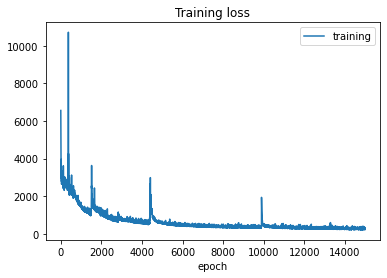

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.legend(['training'])
plt.title('Training loss')
plt.xlabel('epoch')

In [19]:
prediction = model.predict(Y)
close_test = Y.reshape((-1))
prediction = prediction.reshape((-1))

absolute_errors = np.abs(np.subtract(close_test, prediction))
relative_errors = np.divide(absolute_errors, close_test) * 100

trace2 = go.Scatter(
    x = [i for i in range (0, 199)],
    y = prediction,
    name = 'Prediction',
    mode='lines',
    line=dict(width=4, color='Green')
)
trace3 = go.Scatter(
    x = [i for i in range (0, 199)],
    y = close_test,
    mode='markers+lines',
    name = 'Test Data'
)
layout = go.Layout(
    title = "Covid Cases",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace2, trace3], layout=layout)
fig.show()

In [20]:
# mediana błedu względnego
print("Mediana błedu bezwzględnego wynosi: " + str(np.median(absolute_errors)))
print("Najwieksza pomyłka wynosi blisko: "+ str(int(np.ceil(max(relative_errors)))) + " %")

Mediana błedu bezwzględnego wynosi: 382.484619140625
Najwieksza pomyłka wynosi blisko: 6 %


In [21]:
np.argmax(relative_errors)

76

In [23]:
# Błedy wzgledne w %
np.round(relative_errors, 2)

array([5.49, 5.46, 5.37, 4.99, 5.26, 5.44, 5.44, 5.42, 5.4 , 5.22, 4.77,
       5.23, 5.43, 5.45, 5.38, 5.36, 5.24, 4.7 , 5.19, 5.43, 5.41, 5.38,
       5.37, 5.24, 4.66, 5.13, 5.44, 5.44, 5.4 , 5.42, 5.31, 4.72, 5.3 ,
       5.52, 5.54, 5.53, 5.52, 5.44, 5.11, 5.4 , 5.62, 5.62, 5.6 , 5.62,
       5.57, 5.25, 5.49, 5.67, 5.67, 5.67, 5.66, 5.64, 5.39, 5.56, 5.69,
       5.72, 5.7 , 5.72, 5.69, 5.59, 5.65, 5.74, 5.75, 5.74, 5.75, 5.72,
       5.66, 5.68, 5.76, 5.77, 5.77, 5.76, 5.76, 5.69, 5.72, 5.77, 5.77,
       5.76, 5.75, 5.73, 5.56, 5.5 , 5.66, 5.75, 5.75, 5.74, 5.72, 5.61,
       5.64, 5.72, 5.72, 5.69, 5.67, 5.62, 5.46, 5.54, 5.65, 5.63, 5.59,
       5.55, 5.45, 5.02, 5.35, 5.53, 5.51, 5.43, 5.41, 5.23, 4.71, 4.59,
       5.11, 5.4 , 5.38, 5.25, 5.1 , 4.43, 4.92, 5.12, 5.07, 4.97, 4.86,
       4.52, 3.25, 4.18, 4.62, 4.47, 4.13, 3.94, 3.16, 0.67, 2.96, 3.57,
       3.49, 2.79, 2.11, 0.85, 2.85, 0.92])

In [45]:
def predict_next_day(test_data):
  test_data = test_data.reshape((1, 14, n_features))
  return int(np.round(model.predict(test_data, verbose=1)))
next_day = predict_next_day(np.array(cases[-14:]))
print(next_day)
print("Przewidywany margines błędu: [" + str(np.round(next_day - np.median((relative_errors/100)*next_day))) + " ; " +  str(np.round(next_day + np.median((relative_errors/100)*next_day))) + "]")

1/1 [==============================] - 0s 14ms/step
502
Przewidywany margines błędu: [475.0 ; 529.0]


In [46]:
np.median(absolute_errors)

382.484619140625

In [47]:
#współczynnik zmienności w procentach
np.std(cases)/np.mean(cases) * 100 

81.83784931354369

In [ ]:
len(prediction)

137

In [ ]:
len(close_test)

137